<a href="https://colab.research.google.com/github/Sergei-Volkov/CellsCounter/blob/main/NeuralNetworkTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2 as cv

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Физтех/ООП проект/Эмбриологические_снимки/SyntheticCellsDataset'
os.chdir(path)

In [ ]:
image_mask_pairs = []
rgb_weights = [0.2989, 0.5870, 0.1140]
for percent in ['00', '15', '30', '45', '60']:
  files_images = sorted(next(os.walk(path + '/synthetic_0' + percent + '_images'))[-1], key=lambda k: int(k[:-8]))
  files_masks = sorted(next(os.walk(path + '/synthetic_0' + percent + '_foreground'))[-1], key=lambda k: int(k[:-4]))
  for fileI, fileM in zip(files_images, files_masks):
    img = np.dot(cv.imread(path + '/synthetic_0' + percent + '_images/' + fileI), rgb_weights)
    mask = np.dot(cv.imread(path + '/synthetic_0' + percent + '_foreground/' + fileM), rgb_weights)
    image_mask_pairs.append((img, mask))

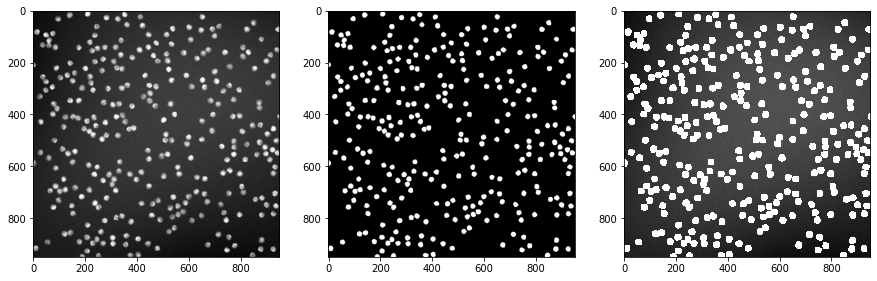

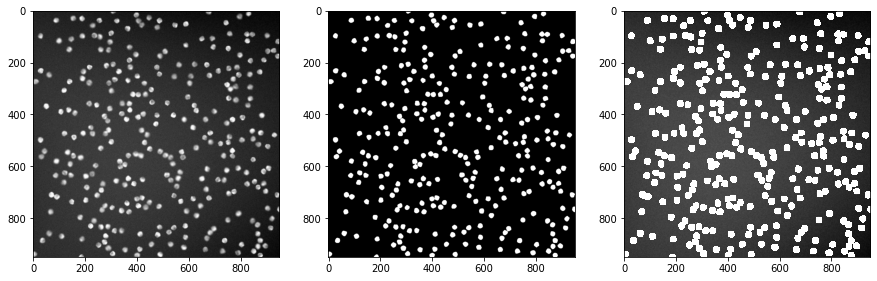

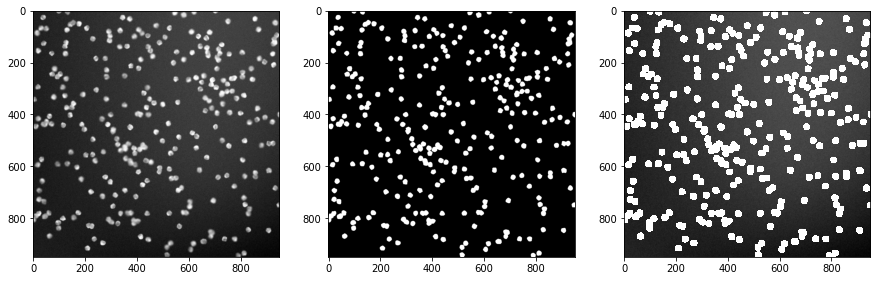

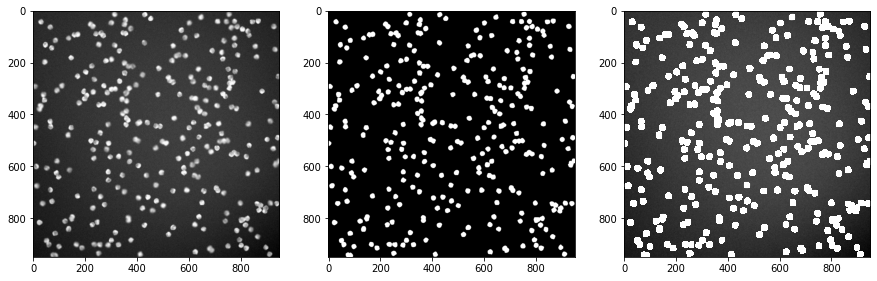

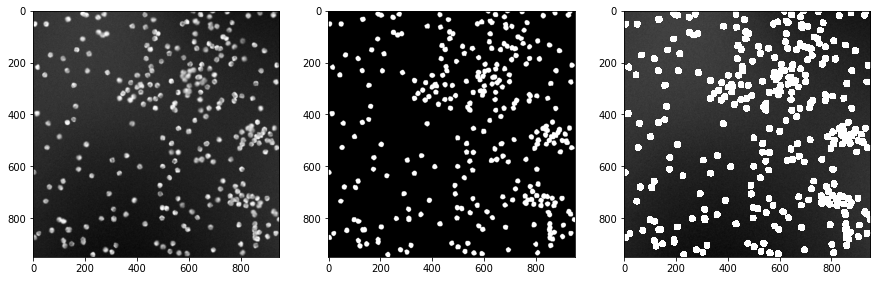

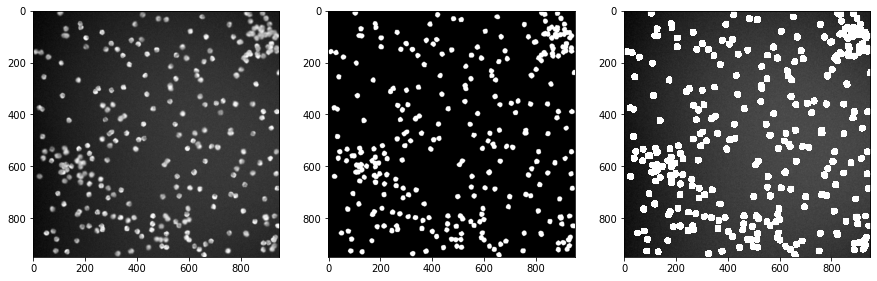

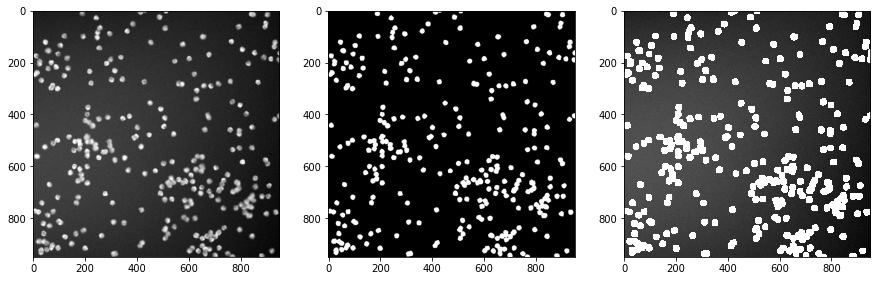

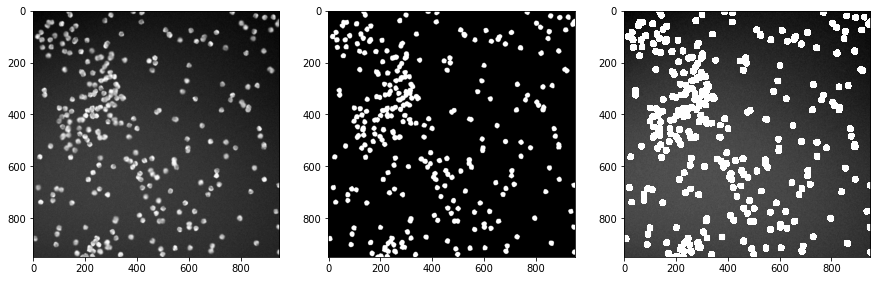

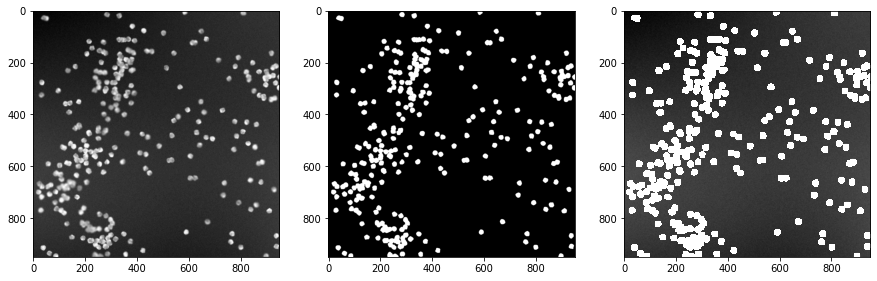

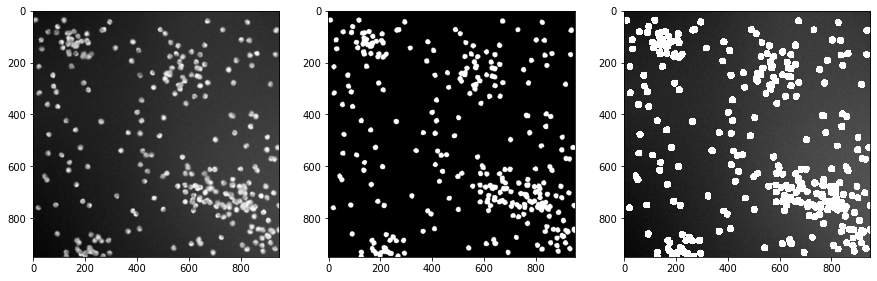

In [14]:
for img, mask in image_mask_pairs[::10]:
  plt.figure(figsize=(15, 15))
  plt.subplot(1, 3, 1)
  plt.imshow(img, cmap='gray')
  plt.subplot(1, 3, 2)
  plt.imshow(mask, cmap='gray')
  plt.subplot(1, 3, 3)
  plt.imshow(np.ma.masked_where(mask, img), cmap='gray')
  plt.show()